In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from SpectralLayer import*
from utilsSimpleConv2D import*
from spectralconvolutions import *

from tensorflow.keras.layers import Layer, Dense
from typing import Tuple,List,Any,Dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
## Data

In [53]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test=x_train.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1)

x_train, x_test = x_train / 255.0, x_test / 255.0

flat_train = np.reshape(x_train, [x_train.shape[0], 28 * 28])
flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])

In [54]:
## Class PaddingJacobiens

In [55]:
## class SpecConv2D

In [56]:
## Create layer specConv2D

In [57]:
N=6
M=6
F=3
S=1
filters=1

In [58]:
img=np.random.normal(0, 1,size=(1,N,M,1))
print(f"Image d'entrée: {img}")

Image d'entrée: [[[[ 1.47275423e+00]
   [-5.99311686e-01]
   [ 6.40728982e-01]
   [-1.29415510e+00]
   [-1.10409355e-01]
   [-1.22850953e+00]]

  [[-9.30582917e-02]
   [-4.73868746e-01]
   [-1.65915329e+00]
   [-1.50144159e+00]
   [-1.01497339e+00]
   [-2.47261191e-01]]

  [[ 8.08957266e-02]
   [ 8.01404675e-01]
   [-1.17448435e+00]
   [ 2.21797750e-01]
   [-1.46249180e+00]
   [ 7.63122303e-01]]

  [[ 7.11016915e-01]
   [-1.47835343e+00]
   [ 7.20946576e-01]
   [-9.13724149e-01]
   [-1.14038061e-01]
   [ 4.51680979e-01]]

  [[ 6.19263004e-01]
   [ 3.50145069e-01]
   [ 1.23947839e+00]
   [-1.05028096e+00]
   [-1.01655638e+00]
   [-7.47895356e-01]]

  [[-9.37658635e-01]
   [ 7.09283575e-01]
   [ 5.06731555e-01]
   [-8.13723081e-01]
   [ 6.44310314e-01]
   [-9.52519117e-04]]]]


In [59]:
#inputs=tf.keras.layers.Input(shape=(28,28,2))
layer1=PaddingJacobiens(kernel_size=F,
                       strides=S,
                        padding="VALID")
outputs1=layer1(img)
#print(f"Outputs1: {outputs1}")
layer2=SpecConv2D(filters=filters,
                 kernel_size=F,
                 use_lambda_in=True,
                 use_bias=False,
                 activation=None)
outputs2=layer2(outputs1)
print(f"Outputs2: {outputs2}")

Outputs2: [[[[-0.8058014 ]
   [ 1.5486453 ]
   [-0.45801234]
   [ 0.5597087 ]]

  [[ 0.21313316]
   [-0.6348072 ]
   [-1.4208629 ]
   [-1.1718045 ]]

  [[ 2.1122625 ]
   [-2.34836   ]
   [-1.6536478 ]
   [ 0.69552624]]

  [[-1.6076075 ]
   [ 0.8672277 ]
   [-0.65719736]
   [-0.8960955 ]]]]


In [60]:
noyau=tf.constant(np.ones((F,F)),dtype=tf.float32)
print(f"Convolution Classique:\n {convolution(img=img[0,:,:,0],kernel=noyau)}")

Convolution Classique:
 [[ 0.30651549 -0.7119088  -4.8872013  -4.9394035  -5.3967505  -2.6011536 ]
 [ 1.1888158  -1.0040928  -5.038483   -7.354582   -5.874322   -3.300523  ]
 [-0.4519632  -2.564654   -5.4568768  -6.8975625  -3.8173296  -1.6239609 ]
 [ 1.0843719   1.8703125  -1.2830704  -3.5493526  -3.8683853  -2.1261783 ]
 [-0.02630341  2.440853   -0.7294963  -0.79685587 -3.5611792  -0.7834511 ]
 [ 0.741033    2.487243    0.94163465 -0.49004024 -2.985098   -1.121094  ]]


In [61]:
## Build model

In [65]:
epochs = 10
batch_size=200
accuracy=list()

spectral_config={
    'is_base_trainable' : False,
    'is_diag_start_trainable' : False,
    'is_diag_end_trainable' : True,
}
N2=[20,80,100,500,800,1000,1500,2000]

for i in range(len(N2)):
    print(f"Iteration {i}: nombre de neurones: {N2[i]}")
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28,28,1)))
    
    #model.add(PaddingJacobiens(kernel_size=3, strides=1, padding="VALID"))
    model.add(SpecConv2D(filters=1, kernel_size=3,use_lambda_in=True,use_bias=False, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))     
    
    model.add(tf.keras.layers.Flatten())     
    
    model.add(Spectral(N2[i], **spectral_config,use_bias=False, activation=None))
    model.add(Spectral(10, **spectral_config,use_bias=False, activation='softmax'))
           
    opt = tf.keras.optimizers.Adam(learning_rate=0.03)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0,validation_data=(x_test, y_test))
    accuracy.append(model.evaluate(x_test,y_test,batch_size=32,verbose="auto"))

Iteration 0: nombre de neurones: 20
313/313 [==============================] - 6s 18ms/step - loss: 1.0059 - accuracy: 0.6605
Iteration 1: nombre de neurones: 80
313/313 [==============================] - 6s 18ms/step - loss: 0.7660 - accuracy: 0.7661
Iteration 2: nombre de neurones: 100
313/313 [==============================] - 5s 17ms/step - loss: 0.7257 - accuracy: 0.7819
Iteration 3: nombre de neurones: 500
313/313 [==============================] - 6s 16ms/step - loss: 0.6150 - accuracy: 0.8095
Iteration 4: nombre de neurones: 800
313/313 [==============================] - 7s 21ms/step - loss: 0.6640 - accuracy: 0.8031
Iteration 5: nombre de neurones: 1000
313/313 [==============================] - 6s 18ms/step - loss: 0.6258 - accuracy: 0.8039
Iteration 6: nombre de neurones: 1500
313/313 [==============================] - 6s 16ms/step - loss: 0.5975 - accuracy: 0.8214
Iteration 7: nombre de neurones: 2000
313/313 [==============================] - 6s 18ms/step - loss: 0.6352 - 

In [ ]:
score=list()
for i in range(len(N2)):
    score.append(accuracy[i][1])

In [12]:
## Dense

In [16]:

accuracy2=list()
N2=[20,80,100,500,800,1000,1500,2000]
epochs = 10
batch_size=200

for i in range(len(N2)):
    print(f"Iteration {i}: nombre de neurones: {N2[i]}")
    model2 = tf.keras.Sequential()
    model2.add(tf.keras.layers.Input(shape=(28,28,1)))
    
    
    model2.add(tf.keras.layers.Conv2D(1,(3,3), strides=1,use_bias=False,padding='VALID',activation="relu"))
    model2.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model2.add(tf.keras.layers.Flatten())  
    
    
    model2.add(Dense(N2[i],use_bias=False,activation=None))
    model2.add(Dense(10, use_bias=False, activation='softmax'))
    
               
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0,validation_data=(x_test, y_test))
    accuracy2.append(model2.evaluate(x_test,y_test,batch_size=32,verbose="auto"))

Iteration 0: nombre de neurones: 20
313/313 [==============================] - 1s 3ms/step - loss: 0.2851 - accuracy: 0.9211
Iteration 1: nombre de neurones: 80
313/313 [==============================] - 1s 3ms/step - loss: 0.2848 - accuracy: 0.9185
Iteration 2: nombre de neurones: 100
313/313 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.9195
Iteration 3: nombre de neurones: 500
313/313 [==============================] - 1s 3ms/step - loss: 0.3026 - accuracy: 0.9064
Iteration 4: nombre de neurones: 800
313/313 [==============================] - 1s 3ms/step - loss: 0.2939 - accuracy: 0.9147
Iteration 5: nombre de neurones: 1000
313/313 [==============================] - 1s 3ms/step - loss: 0.2983 - accuracy: 0.9124
Iteration 6: nombre de neurones: 1500
313/313 [==============================] - 1s 4ms/step - loss: 0.2815 - accuracy: 0.9202
Iteration 7: nombre de neurones: 2000
313/313 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy

In [17]:
score2=list()
for i in range(len(N2)):
    score2.append(accuracy2[i][1])

In [18]:
## PLot

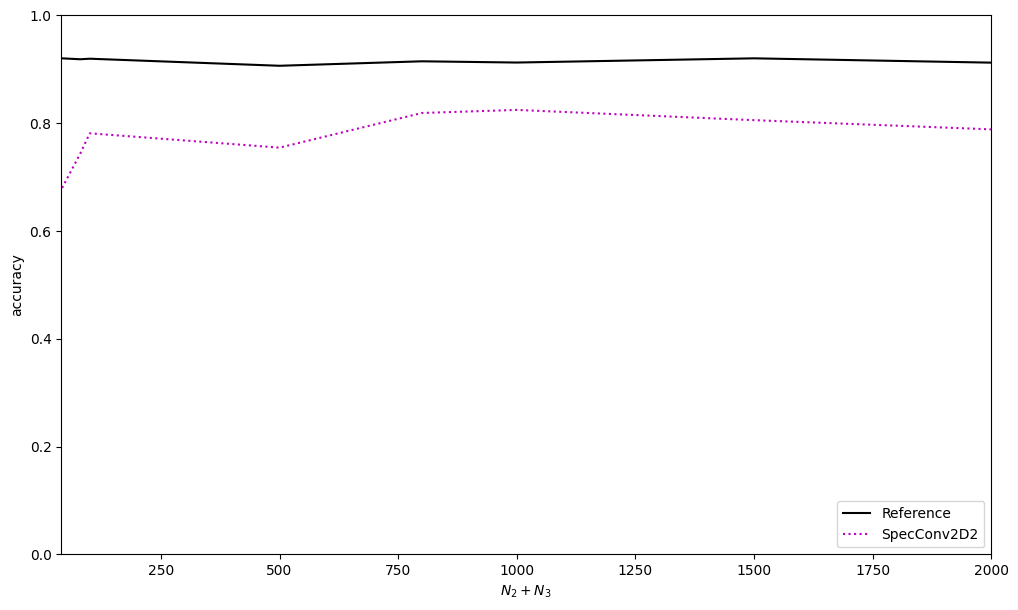

In [66]:
fig=plt.figure(num=1,figsize=(12,7)) 
plt.plot(N2,score2, "k-")
plt.plot(N2,score, "m:")


plt.axis([40, 2000, 0, 1])


plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("accuracy")

 #'ConvNet constraint',
plt.legend(['Reference',
           'SpecConv2D2'],
           loc='lower right')
plt.show()